In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendarUSFH
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

from time import time
import logging
import pylab as pl

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
from sklearn.decomposition import IncrementalPCA
from  sklearn.neural_network import MLPRegressor

/Users/Robert/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Robert/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('data/trip_train.csv')

In [3]:
test = pd.read_csv('data/trip_test.csv')

In [4]:
weather = pd.read_csv('data/weather.csv')

In [5]:
station = pd.read_csv('data/station.csv')

In [6]:
#Preprocesing

In [7]:
stationReduced = station.loc[:,['id','name','city']]

def choseZipCode(city):
    if city == 'San Francisco' : return 94107
    elif city == 'San Jose' : return 95113
    elif city == 'Redwood City' : return 94063
    elif city == 'Palo Alto' : return 94301
    elif city == 'Mountain View' : return 94041

stationReduced['zip_code'] = stationReduced.loc[:,'city'].apply(choseZipCode)

stationProcesed = stationReduced.drop(labels=['name','city'],axis=1)


In [8]:
stationProcesed.head()

,id,zip_code
0,2,95113
1,3,95113
2,4,95113
3,5,95113
4,6,95113


In [9]:
test = test.drop(labels=['zip_code',\
                         'end_date',\
                         'end_station_name',\
                         'end_station_id',\
                         'bike_id'],\
                 axis=1)

In [10]:
train = train.drop(labels=['zip_code',\
                           'end_date',\
                           'end_station_name',\
                           'end_station_id',\
                           'bike_id'],\
                   axis=1)

In [11]:
weather['precipitation_inches'] = weather['precipitation_inches'].apply(lambda x : 0.005 if (x == 'T') else float(x))

In [12]:

weather = weather[weather.precipitation_inches.isnull() == False]

weather = weather.fillna(0)

weather['events'] = weather['events'].apply(lambda x : 'Normal' if x == 0 else x)
weather['events'] = weather['events'].apply(lambda x : 'Rain' if x == 'rain' else x)
weather['date'] = weather['date'].apply(lambda date : pd.to_datetime(date).date())

In [13]:
weather.dtypes

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                          

In [14]:
# PreProcessing trips

In [15]:
train.head()

,id,duration,start_date,start_station_name,start_station_id,subscription_type
0,907649,396,8/27/2015 8:36,Harry Bridges Plaza (Ferry Building),50,Subscriber
1,384043,636,7/28/2014 22:06,Market at 10th,67,Subscriber
2,316176,334,6/9/2014 8:42,Market at Sansome,77,Subscriber
3,618874,666,1/26/2015 16:55,San Francisco Caltrain 2 (330 Townsend),69,Subscriber
4,910977,318,8/29/2015 15:09,Market at 10th,67,Subscriber


In [16]:
def splitDateAndTime(dateAndTime):
    splitLine = dateAndTime.split(' ')
    return str(splitDate(splitLine[0]))  + splitTime(splitLine[1])

def splitDate(date):
    lineSplit = date.split('/')
    return str(lineSplit[2]) + str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + str(lineSplit[1] if int(lineSplit[1]) >= 10 else '0' + str(lineSplit[1]) )

def splitTime(time):
    lineSplit = time.split(':')
    return str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + str(lineSplit[1])


In [17]:
train['time'] = train['start_date'].apply(lambda x : int(splitDateAndTime(x)[8:10]) )
test['time'] = test['start_date'].apply(lambda x : int(splitDateAndTime(x)[8:10]) )

In [18]:
train.loc[:,'start_date'] = train['start_date'].apply(lambda x : pd.to_datetime(splitDateAndTime(x)))
test.loc[:,'start_date'] = test['start_date'].apply(lambda x : pd.to_datetime(splitDateAndTime(x)))


In [19]:
train.loc[:,'day_of_week'] = train['start_date'].apply(lambda x : x.dayofweek )
test.loc[:,'day_of_week'] = test['start_date'].apply(lambda x : x.dayofweek )

In [20]:
train.loc[:,'month'] = train['start_date'].apply(lambda x : x.month )
test.loc[:,'month'] = test['start_date'].apply(lambda x : x.month )

In [21]:
train.loc[:,'year'] = train['start_date'].apply(lambda x : x.year )
test.loc[:,'year'] = test['start_date'].apply(lambda x : x.year )

In [22]:
train.loc[:,'dayofyear'] = train['start_date'].apply(lambda x : x.dayofyear )
test.loc[:,'dayofyear'] = test['start_date'].apply(lambda x : x.dayofyear )

In [23]:
train.loc[:,'start_date'] = train['start_date'].apply(lambda x : pd.to_datetime(x).date())
test.loc[:,'start_date'] = test['start_date'].apply(lambda x : pd.to_datetime(x).date())


In [24]:
cal = calendarUSFH()
holidays = cal.holidays(return_name=True,start=pd.to_datetime('20130101'), end=pd.to_datetime('20151231'))
holiday_festive_day = pd.DataFrame(holidays,columns=['holiday']).reset_index()
holiday_festive_day.rename(columns={'index':'start_date'},inplace=True)

In [25]:
holiday_festive_day.loc[:,'start_date'] = holiday_festive_day['start_date'].apply(lambda x : pd.to_datetime(x).date())

In [26]:
train = pd.merge(holiday_festive_day,train,on=['start_date'],how='right')
test = pd.merge(holiday_festive_day,test,on=['start_date'],how='right')
test.shape

(119998, 11)

In [27]:
train.loc[:,'is_holiday'] = train.holiday.isnull()
test.loc[:,'is_holiday'] = test.holiday.isnull()

In [28]:
train.loc[:,'is_holiday'] = train['is_holiday'].apply(lambda x : not x )
test.loc[:,'is_holiday'] = test['is_holiday'].apply(lambda x : not x )
test.shape

(119998, 12)

In [29]:
train.loc[:,'subscription_type'] = train['subscription_type'].apply(lambda x : 0 if ('Subscriber' == x) else 1 )
test.loc[:,'subscription_type'] = test['subscription_type'].apply(lambda x : 0 if ('Subscriber' == x) else 1 )
test.shape

(119998, 12)

In [30]:
#Merging dataframes

In [31]:
stationProcesed.rename(columns={'id':'start_station_id'},inplace=True)


In [32]:
train2 = pd.merge(train,\
                  stationProcesed,\
                  on= ['start_station_id'],\
                  how='inner')

test2 = pd.merge(test,\
                  stationProcesed,\
                  on= ['start_station_id'],\
                  how='inner')


In [33]:
# Preprocessing trips

In [34]:
train2 = train2.drop(labels=['holiday'],axis=1).dropna()

test2 = test2.drop(labels=['holiday'],axis=1).dropna()

In [35]:
train2.rename(columns={'start_date':'date'},inplace=True)
test2.rename(columns={'start_date':'date'},inplace=True)

In [36]:
# merging with weather, trainN where N - 1 count merges

In [37]:
train3 = pd.merge(train2,weather,\
                  on=['date','zip_code'],\
                  how='left')

test3 = pd.merge(test2,weather,\
                 on=['date','zip_code'],\
                 how='left')

In [38]:
train3.rename(columns={'start_station_id':'station_id'},inplace=True)

test3.rename(columns={'start_station_id':'station_id'},inplace=True)

In [39]:
# register with nan values in weather

In [40]:
nan_rows_test = test3[test3.isnull().T.any().T]
nan_rows_test.shape# 3 registers


(3, 34)

In [41]:
train3
nan_rows_train = train3[train3.isnull().T.any().T]
nan_rows_train#11 registers

,date,id,duration,start_station_name,station_id,subscription_type,time,day_of_week,month,year,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees
480775,2015-08-08,881327,4398,University and Emerson,35,1,10,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480776,2015-08-08,881430,8274,University and Emerson,35,1,12,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480777,2015-08-08,881675,2574,University and Emerson,35,1,18,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480778,2015-08-08,881487,3581,University and Emerson,35,1,14,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480779,2015-08-08,881429,8274,University and Emerson,35,1,12,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480780,2015-08-08,881331,4289,University and Emerson,35,1,10,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480781,2015-08-08,881326,4435,University and Emerson,35,1,10,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531946,2015-08-08,881451,1755,Cowper at University,37,1,13,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531947,2015-08-08,881341,3123,Cowper at University,37,1,11,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533503,2015-08-08,881512,6104,Palo Alto Caltrain Station,34,1,14,5,8,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# zeros in nan values'test3

In [43]:
train3 = train3.dropna()
test3 = test3.fillna(0)

In [44]:
test3.shape

(119998, 34)

In [45]:
train3.shape

(549950, 35)

In [46]:
train3.dtypes

date                               object
id                                  int64
duration                            int64
start_station_name                 object
station_id                          int64
subscription_type                   int64
time                                int64
day_of_week                         int64
month                               int64
year                                int64
dayofyear                           int64
is_holiday                           bool
zip_code                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    

In [47]:
import sklearn.preprocessing
def numberEvents(df):
    df['events'] = df.events.apply(eventNumber)

def eventNumber(eventString):
    if eventString == 'Normal' or eventString == 0: return 0
    elif eventString == 'Rain': return 1
    elif eventString == 'Fog': return 2
    elif eventString == 'Fog-Rain': return 3
    else: return 4
    
def cleanEvents(df):
    df['events'] = df.events.apply(lambda x: "Normal" if pd.isnull(x) else x)
    df['events'] = df.events.apply(lambda x: "Rain" if x == "rain" else x)

def encode(df):
    encoder = sklearn.preprocessing.OneHotEncoder()
    return pd.DataFrame(encoder.fit_transform(df).toarray())

In [48]:
train = train3
test = test3

In [49]:
train = train.loc[lambda x: x['duration'] < 1800,:]
#train = train.loc[lambda x: (x['time'] > 6) ,:].loc[lambda x: (x['time'] < 21) ,:]

In [52]:
train.shape

(521182, 35)

In [53]:
y_train = train['duration']

In [54]:
y_train.shape

(521182,)

In [55]:
trainCategories = train.loc[:,['station_id',\
                        'subscription_type',
                       'day_of_week',\
                        'time',\
                       'month'\
                       ]]
testCategories = test.loc[:,['station_id',\
                        'subscription_type',
                       'day_of_week',\
                       'time',\
                       'month',\
                       ]]

In [56]:
trainCategories.shape

(521182, 5)

In [57]:
testCategories.shape

(119998, 5)

In [58]:
trainCategories.head(2)

,station_id,subscription_type,day_of_week,time,month
0,76,1,0,12,9
2,76,1,0,22,9


In [59]:
trainCategories = encode(trainCategories)

In [60]:
testCategories = encode(testCategories)

In [61]:
trainCategories.shape

(521182, 115)

In [62]:
testCategories.shape

(119998, 115)

In [64]:
testNoCategories = test3.iloc[:,12:]
del testNoCategories['events']


In [66]:
trainNoCategories = train3.iloc[:,13:]
del trainNoCategories ['events']


In [231]:
trainNoCategories.head(2)

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees
0,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.9,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0
1,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.9,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0


In [67]:
from sklearn import preprocessing



min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(trainNoCategories)
trainNoCategories = pd.DataFrame(np_scaled)

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(testNoCategories)
testNoCategories = pd.DataFrame(np_scaled)


In [68]:
testNoCategories.shape

(119998, 21)

In [69]:
trainNoCategories.shape

(549950, 21)

In [70]:
testCategories.head(2)

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [71]:
x_train = trainCategories.join(trainNoCategories, lsuffix = 'x',rsuffix='y')


In [72]:
x_test = testCategories.join(testNoCategories, lsuffix = 'x',rsuffix='y')

In [73]:
x_train.head(2)

,0x,1x,2x,3x,4x,5x,6x,7x,8x,9x,...,11y,12y,13y,14y,15y,16y,17y,18y,19y,20y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.661871,0.5,0.5,0.3,0.179688,0.545455,0.263158,0.0,0.75,0.099928
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.661871,0.5,0.5,0.3,0.179688,0.545455,0.263158,0.0,0.75,0.099928


In [74]:
x_train.shape

(521182, 136)

In [75]:
x_test.shape

(119998, 136)

In [76]:
# TESTED
x = pd.read_csv('data/trip.csv',
                   usecols=['id','duration'])
target = pd.read_csv('data/trip_test.csv',
                   usecols=[ 'id'])
testTarget = pd.merge(x,target, how = "inner", on = "id")

In [77]:
## RANDOM FOREST REGRESSION
from sklearn import ensemble

rfr = ensemble.RandomForestRegressor(n_jobs=-1,n_estimators=50,criterion='mse',oob_score=True)

rfr.fit(x_train,y_train)

test_prediction = rfr.predict(x_test)
                              
mean_squared_error(testTarget['duration'],test_prediction)

KeyboardInterrupt: 

In [78]:
## linear regression
from sklearn import datasets, linear_model




# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

pred = regr.predict(x_test)

mean_squared_error(testTarget['duration'], pred)

43063397.888862975

In [79]:
## 
mlp = MLPRegressor()
mlp.fit(x_train, y_train)
pred1 = mlp.predict(x_test)
mean_squared_error(testTarget['duration'], pred1)

43069121.413832508

In [80]:
from sklearn import linear_model

reg = linear_model.BayesianRidge()
reg.fit(x_train, y_train)

predic = reg.predict(x_test)

mean_squared_error(testTarget['duration'],predic)

43063540.069325082

In [81]:
from sklearn import linear_model
reg = linear_model.Ridge (alpha = .5)
reg.fit(x_train,y_train) 
pred1 = mlp.predict(x_test)
mean_squared_error(testTarget['duration'], pred1)

43069121.413832508

In [82]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.1)
reg.fit(x_train,y_train) 
pred1 = mlp.predict(x_test)
mean_squared_error(testTarget['duration'], pred1)

43069121.413832508

In [ ]:
# Author: Florian Wilhelm -- <florian.wilhelm@gmail.com>
# License: BSD 3 clause

import time

from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor

print(__doc__)

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)), ]


for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(x_train, y_train)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(x_test)
    print(name)
    print(mean_squared_error(testTarget['duration'], y_pred))
    print('')

Automatically created module for IPython interactive environment
OLS
43063397.8889



In [186]:
mlp = MLPRegressor()

In [192]:
trainR.head()

,0,1,2,3,4,5,6,7,8,9,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.9,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.9,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.9,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.9,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.9,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0


In [426]:
trainR.iloc[:,:100]

,0x,1x,2x,3x,4x,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [470]:
mlp.fit(train3, duration)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [467]:
duration = train3['duration']
del train3['duration']

In [468]:
duration.shape

(549950,)

In [459]:
#copy = train3
#copy['duration'] = duration 
train3.shape


(549950, 31)

In [461]:
test3.dtypes

date                               object
id                                  int64
start_station_name                 object
station_id                          int64
subscription_type                   int64
time                                int64
day_of_week                         int64
month                               int64
year                                int64
dayofyear                           int64
is_holiday                           bool
zip_code                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     

In [462]:
del test3['id']
del test3['date']
del test3['start_station_name']
del test3['events']

In [466]:
test3.dtypes


station_id                          int64
subscription_type                   int64
time                                int64
day_of_week                         int64
month                               int64
year                                int64
dayofyear                           int64
is_holiday                           bool
zip_code                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              

In [471]:
test3.shape

(119998, 30)

In [473]:
pred1 = mlp.predict(test3)
mean_squared_error(testTarget['duration'], pred1)

In [475]:
mean_squared_error(testTarget['duration'], pred1)

42792436.96510876

In [477]:
testTarget.shape

(119998, 2)

In [479]:
trainR.shape

(543133, 105)

In [480]:
testR.shape

(119998, 105)

In [482]:
train_target.shape

(543133,)

In [486]:
from sklearn import datasets, linear_model




# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(trainR2, train_target2)

pred = regr.predict(testR)

mean_squared_error(testTarget['duration'], pred)



4.231311138847524e+24

In [ ]:
44391761.393892154

In [488]:
trainR2.shape

(536367, 105)

In [489]:
train_target2.shape

(536367,)

In [490]:
testR.shape

(119998, 105)

In [440]:
testTarget['predict'] = pred1

In [441]:
%matplotlib inline

In [445]:
testt = testTarget[['duration', 'predict']]

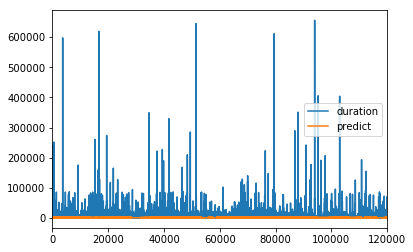

In [446]:
testt.plot()

In [290]:
pca = IncrementalPCA(n_components=8)

In [291]:
#trainR.iloc[:,:101]
testR.iloc[:,:101]

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [292]:
tripTransform = pca.fit_transform(trainR.iloc[:,101:])
tripTransform_test = pca.fit_transform(testR.iloc[:,101:])

In [293]:
tripTransformDF = pd.DataFrame(tripTransform)
tripTransformDF_test = pd.DataFrame(tripTransform_test)

In [294]:
trainRpca = tripTransformDF
testRpca = tripTransformDF_test

In [301]:
trainRpca.shape

(549939, 8)

In [304]:
trainRpca.head()

,0,1,2,3,4,5,6,7
0,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
1,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
2,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
3,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
4,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945


In [302]:
testRpca.shape

(119998, 8)

In [295]:
trainR = trainR.iloc[:,:101].join(trainRpca, lsuffix = 'x',rsuffix='y')
testR = testR.iloc[:,:101].join(testRpca, lsuffix = 'x',rsuffix='y')

In [323]:
print(trainR.shape, trainR.isnull().values.any())
print(train_target.shape, train_target.isnull().values.any())

((549939, 109), True)
((549939,), False)


In [485]:
nonNulls = trainR.notnull().all(axis=1)
trainR2 = trainR[nonNulls]
train_target2 = train_target[nonNulls]

In [416]:
print(trainR2.shape, trainR2.isnull().values.any())
print(train_target2.shape, train_target2.isnull().values.any())

((536367, 105), False)
((536367,), False)


In [305]:
trainR.head()

,0x,1x,2x,3x,4x,5x,6x,7x,8,9,...,99,100,0y,1y,2y,3y,4y,5y,6y,7y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,18.30496,22.690649,16.535694,2.357739,2.996042,1.119105,-0.758394,1.593945


In [326]:

nan_rows_train = trainR2[trainR2.isnull().T.any().T]
nan_rows_train

,0x,1x,2x,3x,4x,5x,6x,7x,8,9,...,99,100,0y,1y,2y,3y,4y,5y,6y,7y


In [337]:
trainR2.shape

(549928, 109)

In [338]:
train3.shape

(549950, 35)

In [303]:
trainR.iloc[:,:101].shape

(549939, 101)

In [412]:
trainR.shape

(543133, 105)

In [417]:
mlp.fit(trainR2, train_target2)

/Users/Robert/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [419]:
pred1 = mlp.predict(testR)

In [422]:
testR.shape

(119998, 105)

In [423]:
trainR.shape

(543133, 105)

In [420]:
mean_squared_error(testTarget['duration'], pred1  )

856048.40661407472

In [421]:
testTarget.to_csv('data/prediction_4_kaggle.csv', index=False)

In [330]:
mean_squared_error(testTarget['duration'], pred1  )

1466136.5121480385

In [331]:
testTarget['duration'] = pred1

In [332]:
testTarget.head()

,id,duration
0,4130,2756.079976
1,4498,2756.079976
2,4557,2756.079976
3,4386,454.239521
4,4242,454.239521


In [333]:
testTarget.to_csv('data/prediction_3_kaggle.csv', index=False)

In [93]:
# probando el ML de braian


In [116]:
trainBR = train3[train3['duration'] < 5000]
trainBR.shape

(536049, 35)

In [95]:
test_id = test3['id']

In [117]:
train_target = trainBR['duration']

In [100]:
trainBR= trainBR.drop(labels=['duration','date','events','id'],axis=1)

In [101]:
testBR = test3.drop(labels=['date','events','id'],axis=1)

In [102]:
from sklearn.decomposition import IncrementalPCA

In [103]:
pca = IncrementalPCA(n_components=8)

In [106]:

del trainBR['start_station_name']
del testBR['start_station_name']

In [107]:
tripTransform = pca.fit_transform(trainBR)
tripTransform_test = pca.fit_transform(testBR)

In [108]:
tripTransform.shape

(536049, 8)

In [109]:
tripTransform_test.shape

(119998, 8)

In [110]:
tripTransformDF = pd.DataFrame(tripTransform)
tripTransformDF_test = pd.DataFrame(tripTransform_test)

In [121]:
trainBR = tripTransformDF
testBR = tripTransformDF_test

In [112]:
from sklearn import ensemble

In [113]:
from sklearn import ensemble
rfr = ensemble.RandomForestRegressor(n_jobs=-1,n_estimators=50,criterion='mse',oob_score=True)
rfr.fit(trainBR,train_target)
test_prediction = rfr.predict(testBR)
mean_squared_error(testTarget['duration'], test_prediction )

In [122]:
train_target.shape

(536049,)

In [123]:
trainBR.shape

(536049, 8)

In [124]:
rfr.fit(trainBR,train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [125]:
test_prediction = rfr.predict(testBR)

In [508]:
x = pd.read_csv('data/trip.csv',
                   usecols=['id','duration'])
target = pd.read_csv('data/trip_test.csv',
                   usecols=[ 'id'])
testTarget = pd.merge(x,target, how = "inner", on = "id")

In [127]:
test_prediction.shape

(119998,)

In [128]:
testTarget.shape

(119998, 2)

In [129]:
testTarget.dtypes

id          int64
duration    int64
dtype: object

In [130]:
from sklearn.metrics import mean_squared_error

In [132]:
mean_squared_error(testTarget['duration'], test_prediction )

42923231.095528767

In [ ]:
42910497

In [133]:
testTarget['duration'] = test_prediction

In [135]:
testTarget.to_csv('data/prediction_1_kaggle.csv', index=False)

In [95]:
train3.head(9)

,date,id,duration,start_station_name,station_id,subscription_type,time,day_of_week,month,year,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees
0,2013-09-02,8808,827,Market at 4th,76,1,12,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
1,2013-09-02,8589,27908,Market at 4th,76,1,9,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
2,2013-09-02,9352,610,Market at 4th,76,1,22,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
3,2013-09-02,8988,7231,Market at 4th,76,1,14,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
4,2013-09-02,9354,12603,Market at 4th,76,1,22,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
5,2013-09-02,9360,11953,Market at 4th,76,1,22,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
6,2013-09-02,8977,1521,Market at 4th,76,1,14,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
7,2013-09-02,9240,9495,Market at 4th,76,1,18,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
8,2013-09-02,9132,1114,Market at 4th,76,1,16,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
